In [87]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random
import plotly 
import plotly.plotly as py
from plotly.graph_objs import *
mapbox_access_token = 'pk.eyJ1IjoiZm4yMTg5IiwiYSI6ImNqOHhueWtuYzIzbXgzNHF6c2Y3NjBydWoifQ.Qpbt8WvvACze5I7S3OqgRA'
plotly.tools.set_credentials_file(username='fn2189', api_key='Np82vvxJvEbQFWAM1pJz')
import re
from statsmodels.nonparametric.kernel_regression import KernelReg
import itertools
import geojson
import json
from shapely.geometry import shape, Point, Polygon
from datetime import datetime
from glob import glob

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR, DynamicVAR
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
# depending on your version, use: from shapely.geometry import shape, Point

# Creating the crime data matrices for 2017

In [3]:
crime_data = pd.read_csv('NYPD_Complaint_Data/NYPD_Complaint_Data_Current_YTD.csv', encoding='utf-8')
crime_data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,417734073,06/30/2017,23:40:00,06/30/2017,23:45:00,06/30/2017,121,CRIMINAL MISCHIEF & RELATED OF,269.0,"MISCHIEF,CRIMINAL, UNCL 2ND",...,90,INSIDE,FAST FOOD,NaN,NaN,1000157.0,194732.0,40.701165,-73.942633,"(40.701165044, -73.942632596)"
1,433995840,06/30/2017,23:20:00,06/30/2017,23:24:00,06/30/2017,578,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",...,32,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,NaN,1001751.0,241630.0,40.829885,-73.936762,"(40.829884885, -73.936761711)"
2,641950009,06/30/2017,23:16:00,06/30/2017,23:17:00,06/30/2017,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",...,73,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,NaN,1009835.0,184539.0,40.673165,-73.907767,"(40.673164918, -73.90776746)"
3,220585856,06/30/2017,23:15:00,06/30/2017,23:20:00,06/30/2017,105,ROBBERY,366.0,"ROBBERY,BICYCLE",...,9,FRONT OF,FAST FOOD,NaN,NaN,987358.0,204898.0,40.729082,-73.988788,"(40.729082038, -73.988787701)"
4,272762078,06/30/2017,23:10:00,06/30/2017,23:15:00,06/30/2017,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",...,47,FRONT OF,STREET,NaN,NaN,1022347.0,261604.0,40.884643,-73.862225,"(40.884642655, -73.862224781)"


In [4]:
crime_data_historic = pd.read_csv('NYPD_Complaint_Data/NYPD_Complaint_Data_Historic.csv', encoding='utf-8')
crime_data = pd.concat([crime_data, crime_data_historic])
crime_data.shape

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.



(5807406, 24)

In [5]:
print('min of latitude: {}'.format(min(crime_data['Latitude'])))
print('max of latitude: {}'.format(max(crime_data['Latitude'])))
print('min of longitude: {}'.format(min(crime_data['Longitude'])))
print('max of longitude: {}'.format(max(crime_data['Longitude'])))

min of latitude: 40.498060701
max of latitude: 40.912723396
min of longitude: -74.255075543
max of longitude: -73.70031585699999


In [4]:
one_day = crime_data[crime_data['CMPLNT_FR_DT'] == '01/30/2017']
set(one_day['OFNS_DESC'])


{'ADMINISTRATIVE CODE',
 'ARSON',
 'ASSAULT 3 & RELATED OFFENSES',
 'BURGLARY',
 'CHILD ABANDONMENT/NON SUPPORT',
 'CRIMINAL MISCHIEF & RELATED OF',
 'CRIMINAL TRESPASS',
 'DANGEROUS DRUGS',
 'DANGEROUS WEAPONS',
 'FELONY ASSAULT',
 'FORGERY',
 'FRAUDS',
 'GRAND LARCENY',
 'GRAND LARCENY OF MOTOR VEHICLE',
 'HARRASSMENT 2',
 'INTOXICATED & IMPAIRED DRIVING',
 'MISCELLANEOUS PENAL LAW',
 'MURDER & NON-NEGL. MANSLAUGHTER',
 'NYS LAWS-UNCLASSIFIED FELONY',
 'OFF. AGNST PUB ORD SENSBLTY &',
 'OFFENSES AGAINST PUBLIC ADMINI',
 'OFFENSES AGAINST THE PERSON',
 'OFFENSES INVOLVING FRAUD',
 'OTHER OFFENSES RELATED TO THEF',
 'PETIT LARCENY',
 'POSSESSION OF STOLEN PROPERTY',
 'RAPE',
 'ROBBERY',
 'SEX CRIMES',
 'THEFT-FRAUD',
 'UNAUTHORIZED USE OF A VEHICLE',
 'VEHICLE AND TRAFFIC LAWS'}

In [5]:
def subset_crime_hour(day='01/30/2017', hour='00:00:00', t='PETIT LARCENY'):
    """
    day: 'MM/DD/YYYY'
    hour:'HH:00:00'
    """
    h = hour.split(':')[0]
    h_plus = str(float(h)+1)+':00:00'
    return crime_data[crime_data['OFNS_DESC'] ==t][np.logical_and(np.logical_and(crime_data['CMPLNT_FR_DT'] == day, crime_data['CMPLNT_FR_TM'] >= hour), crime_data['CMPLNT_FR_TM'] < h_plus)]
#subset_crime('01/30/2017', '12:00:00').head()

In [6]:
def subset_crime_day(day='01/30/2017', t='PETIT LARCENY'):
    """
    day: 'MM/DD/YYYY'
    """
    return crime_data[crime_data['OFNS_DESC'] ==t][crime_data['CMPLNT_FR_DT'] == day]
#subset_crime('01/30/2017', '12:00:00').head()

In [7]:
##Hourly Crime Data
'''
min_x = min(one_day['Latitude'])
max_x = max(one_day['Latitude'])
bins_x = [min_x +a*(max_x - min_x)/16 for a in range(16)]
min_y = min(one_day['Longitude'])
max_y = max(one_day['Longitude'])
bins_y = [min_y +a*(max_y - min_y)/16 for a in range(16)]

days = sorted(set(crime_data[[x.split('/')[2] == '2017' for x in crime_data['CMPLNT_FR_DT']]]['CMPLNT_FR_DT']))
hours = sorted([str(x)+':00:00' for x in range(24)])
sorted_data = []
cpt = 0
for x in days:
    #print(x)
    for y in hours:
        #print(y)
        
        temp = subset_crime_hour(day=x, hour=y, t='PETIT LARCENY')
        if cpt==0:
            print(temp)
        grid = np.histogram2d(x = temp['Latitude'].values, 
                     y = temp['Longitude'].values,
                     bins = [bins_x, bins_y])
        sorted_data.append(grid[0])
        cpt+=1
np.savez('2017_hourly_crime', sorted_data)
'''

"\nmin_x = min(one_day['Latitude'])\nmax_x = max(one_day['Latitude'])\nbins_x = [min_x +a*(max_x - min_x)/16 for a in range(16)]\nmin_y = min(one_day['Longitude'])\nmax_y = max(one_day['Longitude'])\nbins_y = [min_y +a*(max_y - min_y)/16 for a in range(16)]\n\ndays = sorted(set(crime_data[[x.split('/')[2] == '2017' for x in crime_data['CMPLNT_FR_DT']]]['CMPLNT_FR_DT']))\nhours = sorted([str(x)+':00:00' for x in range(24)])\nsorted_data = []\ncpt = 0\nfor x in days:\n    #print(x)\n    for y in hours:\n        #print(y)\n        \n        temp = subset_crime_hour(day=x, hour=y, t='PETIT LARCENY')\n        if cpt==0:\n            print(temp)\n        grid = np.histogram2d(x = temp['Latitude'].values, \n                     y = temp['Longitude'].values,\n                     bins = [bins_x, bins_y])\n        sorted_data.append(grid[0])\n        cpt+=1\nnp.savez('2017_hourly_crime', sorted_data)\n"

In [8]:
##Daily crime data
'''
min_x = min(one_day['Latitude'])
max_x = max(one_day['Latitude'])
bins_x = [min_x +a*(max_x - min_x)/16 for a in range(16)]
min_y = min(one_day['Longitude'])
max_y = max(one_day['Longitude'])
bins_y = [min_y +a*(max_y - min_y)/16 for a in range(16)]

days = sorted(set(crime_data[[x.split('/')[2] == '2017' for x in crime_data['CMPLNT_FR_DT']]]['CMPLNT_FR_DT']))
sorted_data = []
cpt = 0
for x in days:
    
    temp = subset_crime_day(day=x, t='PETIT LARCENY')
    if cpt==0:
        print(temp)
    grid = np.histogram2d(x = temp['Latitude'].values, 
                 y = temp['Longitude'].values,
                 bins = [bins_x, bins_y])
    sorted_data.append(grid[0])
    cpt+=1
    
np.savez('2017_daily_crime', sorted_data)
'''

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



        CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
49370    977316659   01/01/2017     10:00:00   02/01/2017     10:00:00   
57374    700712261   01/01/2017     09:00:00   01/01/2017     16:00:00   
61647    871644413   01/01/2017     10:00:00   01/02/2017     10:00:00   
87691    512152809   01/01/2017     08:00:00   04/26/2017     11:00:00   
124006   392032499   01/01/2017     00:00:00   03/28/2017     09:00:00   
147294   119582114   01/01/2017     12:00:00   03/08/2017     15:00:00   
149755   596549012   01/01/2017     15:10:00          NaN          NaN   
155638   703878749   01/01/2017     17:12:00   03/01/2017     16:30:00   
156968   951075272   01/01/2017     12:00:00   02/01/2017     12:00:00   
161600   993345132   01/01/2017     08:00:00   02/24/2017     08:00:00   
169871   917426129   01/01/2017     09:00:00   02/17/2017     10:00:00   
171095   941517593   01/01/2017     22:00:00          NaN          NaN   
180218   718489127   01/01/2017     00

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:973: RuntimeWarning:

invalid value encountered in greater_equal



In [36]:
l_crime= np.load('2017_daily_crime.npz')
l_crime['arr_0'].shape

(181, 15, 15)

# NYC Grid

Source: https://stackoverflow.com/questions/20776205/point-in-polygon-with-geojson-in-python

We are going to Use geojson to create a grid that covers our area of interest. We start by choosing 15 bins on the x and y axis.
We are then going to use the shapely library to assign each data point to the grid square it belongs to, allowing us to spatially discretize the data.

In [7]:
n_bins_x = 15
n_bins_y = 15
##bining based on the crime data points positions
min_x = min(crime_data['Latitude'])
max_x = max(crime_data['Latitude'])
edges_x = [min_x +a*(max_x - min_x)/(n_bins_x+1) for a in range(n_bins_x+1)]
min_y = min(crime_data['Longitude'])
max_y = max(crime_data['Longitude'])
edges_y = [min_y +a*(max_y - min_y)/(n_bins_y+1) for a in range(n_bins_y+1)]
bins = []
for i in range(n_bins_x):
    for j in range(n_bins_y):
        edges = [[(edges_x[i], edges_y[j]), (edges_x[i+1], edges_y[j]), (edges_x[i+1], edges_y[j+1]), (edges_x[i], edges_y[j+1])]]
        #polygon = geojson.Feature(geometry=geojson.Polygon(edges), id='i,j'.format(i,j))
        polygon = geojson.Feature(geometry=geojson.Polygon(edges), id='{},{}'.format(i,j))
        bins.append(polygon)
grid = geojson.FeatureCollection(bins)
with open('grid.json', 'w') as outfile:
     geojson.dump(grid, outfile)

In [10]:


# load GeoJSON file containing sectors
with open('grid.json') as f:
    grid = json.load(f)


# define a function that check each polygon to see if it contains the point p
def assign (p):
    for feature in grid['features']:
        polygon = shape(feature['geometry'])
        #print(polygon.bounds, feature['id'])
        if polygon.contains(p):
            pos = feature['id'].split(',')
            pos = [int(x) for x in pos]
            return pos





In [9]:
#Assigning each crime to its bin

# Adding point column to crime_data for shapely processing
crime_data['Point'] = crime_data[['Latitude', 'Longitude']].apply(lambda x: Point(float(x[0]), float(x[1])), axis=1)


crime_data['Bin'] = crime_data['Point'].apply(lambda x: assign(x))
crime_data['Bin'].head()


NameError: name 'Crime_data' is not defined

In [13]:
crime_data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,Point,Bin
0,417734073,06/30/2017,23:40:00,06/30/2017,23:45:00,06/30/2017,121,CRIMINAL MISCHIEF & RELATED OF,269.0,"MISCHIEF,CRIMINAL, UNCL 2ND",...,FAST FOOD,NaN,NaN,1000157.0,194732.0,40.701165,-73.942633,"(40.701165044, -73.942632596)",POINT (40.701165044 -73.94263259600001),"[7, 9]"
1,433995840,06/30/2017,23:20:00,06/30/2017,23:24:00,06/30/2017,578,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",...,RESIDENCE - PUBLIC HOUSING,NaN,NaN,1001751.0,241630.0,40.829885,-73.936762,"(40.829884885, -73.936761711)",POINT (40.829884885 -73.936761711),"[12, 9]"
2,641950009,06/30/2017,23:16:00,06/30/2017,23:17:00,06/30/2017,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",...,RESIDENCE - PUBLIC HOUSING,NaN,NaN,1009835.0,184539.0,40.673165,-73.907767,"(40.673164918, -73.90776746)",POINT (40.673164918 -73.90776746),"[6, 10]"
3,220585856,06/30/2017,23:15:00,06/30/2017,23:20:00,06/30/2017,105,ROBBERY,366.0,"ROBBERY,BICYCLE",...,FAST FOOD,NaN,NaN,987358.0,204898.0,40.729082,-73.988788,"(40.729082038, -73.988787701)",POINT (40.729082038 -73.98878770100001),"[8, 7]"
4,272762078,06/30/2017,23:10:00,06/30/2017,23:15:00,06/30/2017,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",...,STREET,NaN,NaN,1022347.0,261604.0,40.884643,-73.862225,"(40.884642655, -73.862224781)",POINT (40.884642655 -73.86222478100001),"[14, 11]"


In [11]:
crime_data.to_csv('Crime_Data_with_bins.csv', index=False, encoding='utf-8')

# School Data

In [10]:
sch_attendance = pd.read_csv('School_Attendance/2015-2017_Historical_Daily_Attendance_By_School.csv', encoding='utf-8')
sch_attendance.School = sch_attendance['School'].astype(str)
sch_attendance['School'].tail()

561694    79X695
561695    79X695
561696    79X695
561697    79X695
561698    79X695
Name: School, dtype: object

In [5]:
allFiles = glob(r'C:\Users\ngamf\Documents\Back_Up\Columbia\Courses\Capstone\School_Attendance/*_Historical_Daily_Attendance_By_School.csv')
l = []
for file in allFiles:
    temp = pd.read_csv(file, encoding='utf-8')
    temp.School = temp['School'].astype(str)
    l.append(temp)

sch_attendance = pd.concat(l)
sch_attendance.tail()

,School,Date,SchoolYear,Enrolled,Present,Absent,Released
561694,79X695,20170621,20162017,281,122,52,107
561695,79X695,20170622,20162017,280,28,34,218
561696,79X695,20170623,20162017,281,120,38,123
561697,79X695,20170627,20162017,274,111,42,121
561698,79X695,20170628,20162017,273,90,56,127


In [6]:
sch_location = pd.read_csv('School_Attendance/2016_-_2017_School_Locations.csv', encoding='utf-8')
sch_location['ATS SYSTEM CODE'] = sch_location['ATS SYSTEM CODE'].apply(lambda x: str(x).strip())
sch_location.head()

,FISCAL_YEAR,ATS SYSTEM CODE,LOCATION_CODE,LOCATION_NAME,BEDS NUMBER,MANAGED_BY_NAME,LOCATION_TYPE_DESCRIPTION,LOCATION_CATEGORY_DESCRIPTION,GRADES_TEXT,GRADES_FINAL_TEXT,...,ADMINISTRATIVE_DISTRICT_NAME,COMMUNITY_SCHOOL_SUP_NAME,FIELD_SUPPORT_CENTER_NAME,FIELD_SUPPORT_CENTER_LEADER_NAME,SCHOOL_SUPPORT_TEAM_NAME,SCHOOL_SUPPORT_TEAM_LEADER_NAME,HIGHSCHOOL_NETWORK_LOCATION_CODE,HIGHSCHOOL_NETWORK_NAME,HIGHSCHOOL_NETWORK_SUPERINTENDENT,Location 1
0,2017,01M015,M015,P.S. 015 Roberto Clemente,310100010015,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",Field Support Center - Manhattan,"CHU, YUET",School Support Team 3- Manhattan,NaN,NaN,NaN,NaN,"MANHATTAN, NY 10009\n(40.722075, -73.978747)"
1,2017,01M019,M019,P.S. 019 Asher Levy,310100010019,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",Field Support Center - Manhattan,"CHU, YUET",School Support Team 3- Manhattan,NaN,NaN,NaN,NaN,"MANHATTAN, NY 10003\n(40.730009, -73.984496)"
2,2017,01M020,M020,P.S. 020 Anna Silver,310100010020,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",Field Support Center - Manhattan,"CHU, YUET",School Support Team 3- Manhattan,NaN,NaN,NaN,NaN,"MANHATTAN, NY 10002\n(40.721305, -73.986312)"
3,2017,01M034,M034,P.S. 034 Franklin D. Roosevelt,310100010034,DOE,General Academic,K-8,"PK,0K,01,02,03,04,05,06,07,08,SE","PK,0K,01,02,03,04,05,06,07,08",...,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",Field Support Center - Manhattan,"CHU, YUET",School Support Team 3- Manhattan,NaN,NaN,NaN,NaN,"MANHATTAN, NY 10009\n(40.726008, -73.975058)"
4,2017,01M063,M063,The STAR Academy - P.S.63,310100010063,DOE,General Academic,Elementary,"PK,0K,01,02,03,04,05,SE","PK,0K,01,02,03,04,05",...,COMMUNITY SCHOOL DISTRICT 01,"PHILLIPS, DANIELLA",Field Support Center - Manhattan,"CHU, YUET",School Support Team 3- Manhattan,NaN,NaN,NaN,NaN,"MANHATTAN, NY 10009\n(40.72444, -73.986214)"


In [7]:
def lat(x):
    pat = re.compile('\((.+),(.+)\)')
    mo = pat.search(x)
    return float(mo.group(1))
def lon(x):
    pat = re.compile('\((.+),(.+)\)')
    mo = pat.search(x)
    return float(mo.group(2))
schools = sch_attendance.merge(right=sch_location[['ATS SYSTEM CODE', 'Location 1']], how='inner', left_on=['School'], right_on=['ATS SYSTEM CODE'] )
schools['Latitude'] = schools['Location 1'].apply(lat)
schools['Longitude'] = schools['Location 1'].apply(lon)
schools['Size'] = schools[['Enrolled', 'Absent']].apply(lambda x: float(x[1])/float(x[0]), axis = 1)
schools.tail()

,School,Date,SchoolYear,Enrolled,Present,Absent,Released,ATS SYSTEM CODE,Location 1,Latitude,Longitude,Size
2856675,31R068,20170621,20162017,58,51,7,0,31R068,"STATEN IS, NY 10302\n(40.624781, -74.142526)",40.624781,-74.142526,0.120690
2856676,31R068,20170622,20162017,58,52,6,0,31R068,"STATEN IS, NY 10302\n(40.624781, -74.142526)",40.624781,-74.142526,0.103448
2856677,31R068,20170623,20162017,58,57,1,0,31R068,"STATEN IS, NY 10302\n(40.624781, -74.142526)",40.624781,-74.142526,0.017241
2856678,31R068,20170627,20162017,58,43,15,0,31R068,"STATEN IS, NY 10302\n(40.624781, -74.142526)",40.624781,-74.142526,0.258621
2856679,31R068,20170628,20162017,58,40,18,0,31R068,"STATEN IS, NY 10302\n(40.624781, -74.142526)",40.624781,-74.142526,0.310345


In [8]:
one_day_schools = schools[schools['Date'] == 20170130]
one_day_schools.head()

,School,Date,SchoolYear,Enrolled,Present,Absent,Released,ATS SYSTEM CODE,Location 1,Latitude,Longitude,Size
1900,01M015,20170130,20162017,173,164,9,0,01M015,"MANHATTAN, NY 10009\n(40.722075, -73.978747)",40.722075,-73.978747,0.052023
3890,01M019,20170130,20162017,269,236,33,0,01M019,"MANHATTAN, NY 10003\n(40.730009, -73.984496)",40.730009,-73.984496,0.122677
5880,01M020,20170130,20162017,541,501,40,0,01M020,"MANHATTAN, NY 10002\n(40.721305, -73.986312)",40.721305,-73.986312,0.073937
7870,01M034,20170130,20162017,350,316,34,0,01M034,"MANHATTAN, NY 10009\n(40.726008, -73.975058)",40.726008,-73.975058,0.097143
9859,01M063,20170130,20162017,199,161,38,0,01M063,"MANHATTAN, NY 10009\n(40.72444, -73.986214)",40.724440,-73.986214,0.190955


In [14]:
lat_0 = (min(one_day_schools['Latitude']) + max(one_day_schools['Latitude']))/2
lon_0 = (min(one_day_schools['Longitude']) + max(one_day_schools['Longitude']))/2

l = []

s = Scattermapbox(
    lat= one_day_schools['Latitude'],
    lon= one_day_schools['Longitude'],
    mode='markers',
    name= 'School ratio of absenteism',
    marker=Marker(
        size=one_day_schools['Size']*100,
        color='rgb(255, 0, 0)'
    ),
    #text=one_day["OFNS_DESC"],
)
l.append(s)
data = Data(l)
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=lat_0,
            lon=lon_0
        ),
        pitch=0,
        zoom=10
    ),
    showlegend= True,
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='schools_ATTENDANCE_6-30-17')

In [11]:
#Assigning each school to it's bin

schools['Point'] = schools[['Latitude', 'Longitude']].apply(lambda x: Point(float(x[0]), float(x[1])), axis=1)
schools['Bin'] = schools['Point'].apply(lambda x: assign(x))
schools['Bin'].head()


0    [8, 7]
1    [8, 7]
2    [8, 7]
3    [8, 7]
4    [8, 7]
Name: Bin, dtype: object

In [13]:
schools.to_csv('Schools_Data_with_bins.csv', index=False, encoding='utf-8')

# Time Series Modelling (VAR)

In [2]:
crime_data = pd.read_csv('Crime_Data_with_bins.csv', encoding='utf-8')
crime_data.head()

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.



,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,Point,Bin
0,417734073,06/30/2017,23:40:00,06/30/2017,23:45:00,06/30/2017,121,CRIMINAL MISCHIEF & RELATED OF,269.0,"MISCHIEF,CRIMINAL, UNCL 2ND",...,FAST FOOD,NaN,NaN,1000157.0,194732.0,40.701165,-73.942633,"(40.701165044, -73.942632596)",POINT (40.701165044 -73.94263259600001),"[7, 9]"
1,433995840,06/30/2017,23:20:00,06/30/2017,23:24:00,06/30/2017,578,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",...,RESIDENCE - PUBLIC HOUSING,NaN,NaN,1001751.0,241630.0,40.829885,-73.936762,"(40.829884885, -73.936761711)",POINT (40.829884885 -73.936761711),"[12, 9]"
2,641950009,06/30/2017,23:16:00,06/30/2017,23:17:00,06/30/2017,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",...,RESIDENCE - PUBLIC HOUSING,NaN,NaN,1009835.0,184539.0,40.673165,-73.907767,"(40.673164918, -73.90776746)",POINT (40.673164918 -73.90776746),"[6, 10]"
3,220585856,06/30/2017,23:15:00,06/30/2017,23:20:00,06/30/2017,105,ROBBERY,366.0,"ROBBERY,BICYCLE",...,FAST FOOD,NaN,NaN,987358.0,204898.0,40.729082,-73.988788,"(40.729082038, -73.988787701)",POINT (40.729082038 -73.98878770100001),"[8, 7]"
4,272762078,06/30/2017,23:10:00,06/30/2017,23:15:00,06/30/2017,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",...,STREET,NaN,NaN,1022347.0,261604.0,40.884643,-73.862225,"(40.884642655, -73.862224781)",POINT (40.884642655 -73.86222478100001),"[14, 11]"


In [3]:
set(crime_data['CMPLNT_FR_DT'])

{nan,
 '10/19/2001',
 '02/02/1920',
 '07/23/2000',
 '03/15/2005',
 '01/10/2001',
 '10/05/2005',
 '05/01/2009',
 '04/14/2004',
 '03/02/2017',
 '09/27/2002',
 '10/22/2001',
 '07/24/2003',
 '04/19/2003',
 '04/09/2016',
 '04/12/2000',
 '11/15/2013',
 '06/19/2004',
 '11/07/2016',
 '02/08/2000',
 '05/26/2007',
 '03/03/2017',
 '05/18/2005',
 '12/17/2007',
 '03/26/2005',
 '12/17/2005',
 '03/15/2015',
 '09/03/2006',
 '07/31/2003',
 '08/24/2014',
 '07/16/2006',
 '05/05/2010',
 '07/05/1997',
 '07/25/2010',
 '03/10/2001',
 '04/12/2004',
 '01/12/2006',
 '07/16/2009',
 '03/08/1998',
 '08/04/2011',
 '10/16/2016',
 '01/16/2003',
 '11/18/1995',
 '11/29/2015',
 '02/17/2010',
 '10/02/2014',
 '11/16/2009',
 '10/23/2012',
 '02/27/2010',
 '09/09/2007',
 '10/09/2005',
 '07/02/2001',
 '08/01/2016',
 '08/18/2015',
 '11/11/2005',
 '05/28/2016',
 '10/20/2004',
 '04/06/2003',
 '07/08/1994',
 '08/24/2006',
 '10/14/2012',
 '05/02/2006',
 '10/01/2000',
 '07/10/1994',
 '05/20/2014',
 '04/02/2006',
 '09/18/2004',
 '08

In [4]:
crime_data['Year'] =  crime_data['CMPLNT_FR_DT'].apply(lambda x: x.split('/')[-1] if type(x) == str else np.nan) 
l = []
years = [x for x in set(crime_data['Year']) if pd.isnull(x) == False]
years = sorted([x for x in years if int(x) >= 2006])
for year in years:
    temp = pd.Series(crime_data[crime_data['Year'] == str(year)].groupby(['Bin', 'CMPLNT_FR_DT', 'OFNS_DESC'])['OFNS_DESC'].count(), name='Count').to_frame()

    bins = set(temp.index.get_level_values(0))
    dates = set(temp.index.get_level_values(1))
    crime = set(temp.index.get_level_values(2))
    idx = list(itertools.product(itertools.product(bins, dates), crime))
    idx = [(x[0][0], x[0][1], x[1]) for x in idx]
    #crimes.index.levels[0]
    temp = temp.reindex(index=idx, fill_value=0).sort_index()
    #print(year, type(temp))
    l.append(temp)
crimes = pd.concat(l)
crimes.head()

Count
Bin    CMPLNT_FR_DT OFNS_DESC                            
[0, 0] 01/01/2006   ADMINISTRATIVE CODE                 0
                    ADMINISTRATIVE CODES                0
                    ALCOHOLIC BEVERAGE CONTROL LAW      0
                    ANTICIPATORY OFFENSES               0
                    ARSON                               0

In [5]:
#Training data, everythin before 2017
year = '2017'
crime = 'PETIT LARCENY'
data = crimes[np.logical_and([x [-4:] < year for x in crimes.index.get_level_values(1)]
                      , [x==crime for x in crimes.index.get_level_values(2)])]
data['Date'] = data.index.map(lambda x: datetime.strptime(x[1], '%m/%d/%Y'))
data.reset_index(level=2, drop=True, inplace=True)
data.reset_index( inplace=True)
dates = list(set(data.Date))
beg = min(dates)
end = max(dates)
date_idx = pd.date_range(start = beg, end=end, freq='D')
X = np.zeros(((max(dates) - min(dates)).days + 1, 15, 15))
def fill(x):
    X[(x[3] - beg).days
       , int(x[0].strip('[').strip(']').split(',')[0])
       , int(x[0].strip('[').strip(']').split(',')[1])] = x[2]

data.apply(fill, axis=1)
for i in range(X.shape[0]):
    if np.max(X[i,:,:]) == 0:
        X[i,:,:] = np.nan
X[0,:,:]

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   2.,   1.,   0.,   3.,   3.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   2.,   2.,   0.,   2.,   1.,   3.,   0.,   1.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   7.,   1.,   5.,
          1.,   0.,   2.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   4.,   2.,   1.,
          0.,   1.,   2.,   2.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,  21.,   2.,   1.,   0.,
          0.,   2.,   1.,   1.],
       [  0.,   0.,   0.,   0.,   0.,

In [6]:
#Test data, 2017
year = '2017'
crime = 'PETIT LARCENY'
data = crimes[np.logical_and([x [-4:] == year for x in crimes.index.get_level_values(1)]
                      , [x==crime for x in crimes.index.get_level_values(2)])]
data['Date'] = data.index.map(lambda x: datetime.strptime(x[1], '%m/%d/%Y'))
data.reset_index(level=2, drop=True, inplace=True)
data.reset_index( inplace=True)
dates = list(set(data.Date))
beg = min(dates)
end = max(dates)
date_idx_2017 = pd.date_range(start = beg, end=end, freq='D')
X_2017 = np.zeros(((max(dates) - min(dates)).days + 1, 15, 15))
def fill(x):
    X_2017[(x[3] - beg).days
       , int(x[0].strip('[').strip(']').split(',')[0])
       , int(x[0].strip('[').strip(']').split(',')[1])] = x[2]

data.apply(fill, axis=1)
for i in range(X_2017.shape[0]):
    if np.max(X_2017[i,:,:]) == 0:
        X_2017[i,:,:] = np.nan
X_2017[0,:,:]

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   2.,   0.,
          0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,   3.,   0.,
          0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   1.,   2.,   0.,   0.,   1.,   6.,   0.,   0.,
          2.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   1.,   3.,   4.,
          4.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   3.,   4.,   1.,
          3.,   2.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,   7.,   1.,   1.,
          1.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,

In [7]:
school_data = pd.read_csv('schools_Data_with_bins.csv', encoding='utf-8')
school_data.head()

,School,Date,SchoolYear,Enrolled,Present,Absent,Released,ATS SYSTEM CODE,Location 1,Latitude,Longitude,Size,Point,Bin
0,01M015,20060905,20062007,252,226,26,0,01M015,"MANHATTAN, NY 10009\r\n(40.722075, -73.978747)",40.722075,-73.978747,0.103175,POINT (40.722075 -73.978747),"[8, 7]"
1,01M015,20060906,20062007,248,227,21,0,01M015,"MANHATTAN, NY 10009\r\n(40.722075, -73.978747)",40.722075,-73.978747,0.084677,POINT (40.722075 -73.978747),"[8, 7]"
2,01M015,20060907,20062007,245,228,17,0,01M015,"MANHATTAN, NY 10009\r\n(40.722075, -73.978747)",40.722075,-73.978747,0.069388,POINT (40.722075 -73.978747),"[8, 7]"
3,01M015,20060908,20062007,246,226,20,0,01M015,"MANHATTAN, NY 10009\r\n(40.722075, -73.978747)",40.722075,-73.978747,0.081301,POINT (40.722075 -73.978747),"[8, 7]"
4,01M015,20060911,20062007,248,223,25,0,01M015,"MANHATTAN, NY 10009\r\n(40.722075, -73.978747)",40.722075,-73.978747,0.100806,POINT (40.722075 -73.978747),"[8, 7]"


In [8]:
school_data['Year'] =  school_data['Date'].apply(lambda x: str(x)[:4]) 
l = []
years = [x for x in set(school_data['Year']) if pd.isnull(x) == False]
years = sorted([x for x in years if int(x) >= 2006])
for year in years:
    temp = pd.Series(school_data[school_data['Year'] == str(year)].groupby(['Bin', 'Date'])['Size'].mean(), name='Mean').to_frame()

    bins = set(temp.index.get_level_values(0))
    dates = set(temp.index.get_level_values(1))
    idx = list(itertools.product(bins, dates))
    #crimes.index.levels[0]
    temp = temp.reindex(index=idx, fill_value=0).sort_index()
    #print(year, type(temp))
    l.append(temp)
attendance = pd.concat(l)
attendance.head()

Mean
Bin    Date              
[0, 0] 20060905  0.017407
       20060906  0.017760
       20060907  0.020286
       20060908  0.029158
       20060911  0.036823

In [9]:
attendance_data = attendance[[year > str(x)[:4]  for x in attendance.index.get_level_values(1)]]
attendance_data['Date 2'] = attendance_data.index.map(lambda x: datetime.strptime(str(x[1]), '%Y%m%d'))

attendance_data.reset_index( inplace=True)

def fill_2(x):
    A[(x[3] - beg).days
       , int(x[0].strip('[').strip(']').split(',')[0])
       , int(x[0].strip('[').strip(']').split(',')[1])] = x[2]

A = np.zeros(X.shape)
data.apply(fill_2, axis=1)
for i in range(A.shape[0]):
    #print(i, np.nanmax(A[i,:,:]))
    if np.nanmax(A[i,:,:]) == 0:
        A[i,:,:] = np.nan
A[2000,:,:]

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,

In [10]:
X = X.reshape(X.shape[0], 15*15)
X_2017 = X_2017.reshape(X_2017.shape[0], 15*15)
A = A.reshape(A.shape[0], 15*15)
X_df = pd.DataFrame(X, index=date_idx)
X_2017_df = pd.DataFrame(X_2017, index=date_idx_2017)
A_df = pd.DataFrame(A, index=date_idx)
X_df.shape, X_2017_df.shape, X_df.head()

((4018, 225),
 (181, 225),
             0    1    2    3    4    5    6    7    8    9   ...   215  216  \
 2006-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
 2006-01-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
 2006-01-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
 2006-01-04  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
 2006-01-05  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
 
             217  218  219  220  221  222  223  224  
 2006-01-01  0.0  0.0  3.0  8.0  4.0  1.0  0.0  0.0  
 2006-01-02  0.0  0.0  3.0  4.0  2.0  1.0  0.0  0.0  
 2006-01-03  0.0  0.0  2.0  5.0  4.0  3.0  0.0  0.0  
 2006-01-04  0.0  0.0  1.0  8.0  1.0  2.0  0.0  0.0  
 2006-01-05  0.0  0.0  1.0  3.0  2.0  1.0  0.0  0.0  
 
 [5 rows x 225 columns])

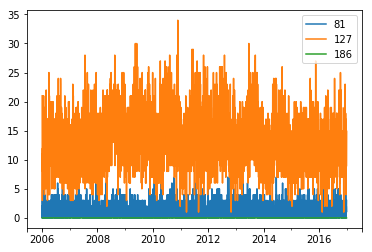

In [11]:
X_df[[81, 127, 186]].plot()

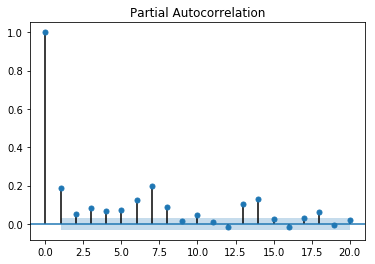

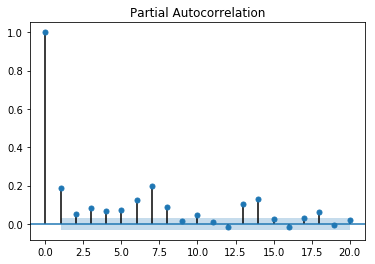

In [12]:
plot_pacf(X_df[127], lags=20, alpha=.05)

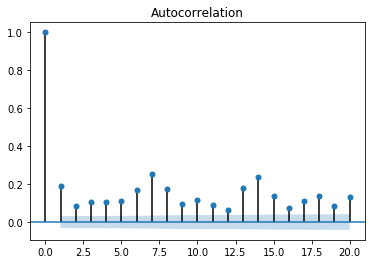

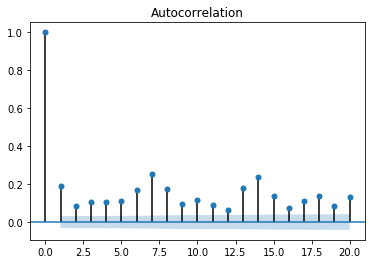

In [13]:
plot_acf(X_df[127], lags=20, alpha=.05)

In [14]:
for i in range(len(X_df.columns)):
    res = adfuller(X_df[i], maxlag=20, regression='ct')
    if i == 0 :
        print('statistic: {}, p_value: {}, maxlag:{}, n_samples: {}, critical values: {}'.format(res[0], res[1], res[2], res[3], res[4] ))
    else:
        print('statistic: {}, p_value: {}'.format(res[0], res[1] ))

statistic: -29.063133397389826, p_value: 0.0, maxlag:3, n_samples: 4014, critical values: {'1%': -3.9610271476179766, '5%': -3.411584333317689, '10%': -3.1276943894411096}
statistic: -40.796056412726465, p_value: 0.0
statistic: -29.089966742601067, p_value: 0.0


C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\statsmodels\regression\linear_model.py:660: RuntimeWarning:

divide by zero encountered in log

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning:

invalid value encountered in greater_equal



statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: -60.96150398273235, p_value: 0.0
statistic: -10.659582330147089, p_value: 1.0199691708866526e-16
statistic: -59.542251277831426, p_value: 0.0
statistic: -19.45165448424319, p_value: 0.0
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: -63.46366168643705, p_value: 0.0
statistic: -15.798417064348492, p_value: 1.1929083390011406e-22
statistic: -14.4296931414848

statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: -10.625959381074505, p_value: 1.1895433984524122e-16
statistic: -8.000990620148652, p_value: 7.107463717144522e-11
statistic: -7.963223605675303, p_value: 8.69028226850441e-11
statistic: -13.592133349565536, p_value: 2.7566311459069123e-21
statistic: -10.64595041820286, p_value: 1.0855155809250955e-16
statistic: -61.436891435952326, p_value: 0.0
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: nan, p_value: nan
statistic: -15.296859980176501, p_value: 1.6243353450872563e-22
statistic: -11.572322251407657, p_value: 2.0113288706391698e-18
statistic: -15.36779

We see that for most of the time series, the hypothesis of a unit root can be rejected, therefore, we are going to learn an arma model on the time series.

## VAR Model
 We need to remove the constant columns for the VAR model function to work and lower the number of sample to avoid memory error
We are going to run the model on the pca matrix, removing the null columns then to predict we will need to transform the predictions back to the initial space.

In [90]:

pca = PCA(n_components = X_df.shape[1])
X_pca = pca.fit_transform(X_df)
X_2017_pca = pca.transform(X_2017)
X_pca.shape, np.linalg.matrix_rank(X_pca), np.cumsum(pca.explained_variance_ratio_)[:20]

((4018, 225),
 124,
 array([ 0.1636313 ,  0.23111413,  0.27784571,  0.30723825,  0.33588002,
         0.36334839,  0.38878829,  0.4135352 ,  0.4357769 ,  0.45777972,
         0.47829359,  0.49854935,  0.51820231,  0.53748227,  0.55626712,
         0.57323794,  0.58961747,  0.60498463,  0.61857848,  0.63191276]))

In [91]:
model = VAR(X_pca[:, :20] )
model

In [92]:
#Selecting the model order based on AIC
model.select_order(20)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         38.63       38.66*    5.993e+16        38.64
1         38.28        38.95    4.235e+16       38.52*
2         38.27        39.56    4.160e+16        38.72
3         38.26        40.18    4.125e+16        38.94
4         38.29        40.84    4.257e+16        39.19
5         38.32        41.50    4.401e+16        39.45
6         38.31        42.12    4.329e+16        39.66
7        38.19*        42.63   3.842e+16*        39.76
8         38.24        43.31    4.058e+16        40.04
9         38.33        44.03    4.436e+16        40.35
10        38.41        44.73    4.788e+16        40.65
11        38.49        45.45    5.236e+16        40.96
12        38.57        46.15    5.631e+16        41.26
13        38.63        46.85    6.008e+16        41.54
14        38.65        47.50    6.136e+16        41.79
15        

{'aic': 7, 'bic': 0, 'fpe': 7, 'hqic': 1}

In [93]:
##Computing the model
results = model.fit(7)#, trend='nc')

results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Nov, 2017
Time:                     10:50:13
--------------------------------------------------------------------
No. of Equations:         20.0000    BIC:                    42.6075
Nobs:                     4011.00    HQIC:                   39.7495
Log likelihood:          -187578.    FPE:                3.81784e+16
AIC:                      38.1805    Det(Omega_mle):     1.91304e+16
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000881         0.091306            0.010           0.992
L1.y1          0.159947         0.015195           10.526           0.000
L1.y2         -0.131700         0.023212           -5.674           0.000
L1.y3         -0.

In [94]:
###Forecasting and computing the least square errors
lag_order_var = results.k_ar
l_forecast_pca = []

for j in range(X_2017.shape[0] - lag_order_var):
    res = results.forecast(X_2017_pca[j:j+lag_order_var,:20], lag_order_var)
    l_forecast_pca.append(res)


In [95]:
X_forecast_pca = np.asarray(l_forecast_pca)
s = X_forecast_pca.shape
X_forecast_pca = X_forecast_pca.reshape((s[1], s[0], s[2]))
X_forecast_pca.shape

(7, 174, 20)

Now in order to go back to the initiial space via pca inverse transform , we need to complete each vector : we only used the 20 most important principal components to compute the VAR model so our predeiction for each of the remaining components will simply be their overall mean. (the asumption here is that the variance on those components is noise and therefore uninformative.

In [96]:
means = np.mean(X_pca[:, 20:], axis=0)
means.shape

(205,)

In [97]:
X_pred_pca = np.zeros((X_forecast_pca.shape[0], X_forecast_pca.shape[1], 225))
X_pred_pca[:,:,:20] = X_forecast_pca
X_pred_pca[:,:,20:] = means


The final prediction X_pred is  the pca inverse of X_pred_pca

In [98]:
X_pred = np.zeros(X_pred_pca.shape)
for i in range(lag_order_var):
    X_pred[i,:,:] = pca.inverse_transform(X_pred_pca[i,:,:])
X_pred = X_pred[:,:-(lag_order_var ), :]
X_pred.shape

(7, 167, 225)

We can now compute the least square residuals

In [100]:

X_true = np.zeros(X_pred.shape)
print(X_true.shape, X_pred.shape)
n_samples = X_pred.shape[1]
for i in range(lag_order_var):
    #print(X_2017[lag_order + i : -(lag_order - i),:].shape)
    X_true[i,:,:] = X_2017[lag_order_var + i: -(lag_order_var - i),:]
residuals = np.sum(np.square(X_true - X_pred), axis = 2)
residuals.shape

(7, 167, 225) (7, 167, 225)


(7, 167)

In [102]:
for i in range(lag_order_var):
    r_2 = mean_squared_error(X_true[i,:,:], X_pred[i,:,:], multioutput='uniform_average')
    print('mean_squared_error for {} steps forecating: {}'.format(i+1, r_2))

mean_squared_error for 1 steps forecating: 1.1219337091548691
mean_squared_error for 2 steps forecating: 1.1467160725172436
mean_squared_error for 3 steps forecating: 1.2267029334830022
mean_squared_error for 4 steps forecating: 1.1348297470583837
mean_squared_error for 5 steps forecating: 1.1445675459479645
mean_squared_error for 6 steps forecating: 1.1594899022398646
mean_squared_error for 7 steps forecating: 1.1388264626925153


## Comparison of the accuracy: individual AR and ARMA models

In [85]:
models = {}
results = {}
offset = 20
X_pred  = np.zeros((lag_order_var, X_2017.shape[0] - offset, X_2017.shape[1]) )
for i in range(X_df.shape[1]):
    print(i)
    try:
        ar = AR(X_df[i])
        lag_order_ar = ar.select_order(maxlag=20, ic='aic')
        model = ARMA(X_df[i], order = (lag_order_ar,0) )
        results[i] = model.fit(trend='c')
        params = results[i].params
        l_forecast = []

        #print(lag_order)

        for j in range(X_2017.shape[0] - offset):
            l = []
            lags = [1] + list(X_2017[j:j+lag_order_ar,i])
            #we compute as many steps as we did with the var for consistency
            for k in range(lag_order_var):
                x = np.dot(params, lags)
                l.append(x)
                lags = [1, x] + lags[1:-1]
            l_forecast.append(l)
        x_pred = np.swapaxes(np.array(l_forecast),0,1)
        X_pred[:,:,i] = x_pred
    except:
        X_pred[:,:,i] = np.mean(X_df[i])
        
    



0
1
2
3


C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\ar_model.py:316: RuntimeWarning:

divide by zero encountered in log

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\ar_model.py:316: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\numpy\linalg\linalg.py:1741: RuntimeWarning:

invalid value encountered in slogdet

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\ngamf\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\ar_model.py:739: RuntimeWarning:

divide by zero encountered in log



4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224


In [86]:
X_pred.shape, X_2017.shape, X_pred.shape

((7, 161, 225), (181, 225), (7, 161, 225))

In [89]:
for i in range(lag_order_var):
    r_2 = mean_squared_error(X_true[i,:161,:], X_pred[i,:,:], multioutput='uniform_average')
    print('mean_squared_error for {} steps forecating: {}'.format(i+1, r_2))

mean_squared_error for 1 steps forecating: 3.508206042093077
mean_squared_error for 2 steps forecating: 4.006785539358586
mean_squared_error for 3 steps forecating: 4.197449243665033
mean_squared_error for 4 steps forecating: 4.366133996769476
mean_squared_error for 5 steps forecating: 4.598394144930011
mean_squared_error for 6 steps forecating: 4.648568773042764
mean_squared_error for 7 steps forecating: 4.975601641203813


In [56]:
np.array(l_forecast).shape

(163, 18)

# #


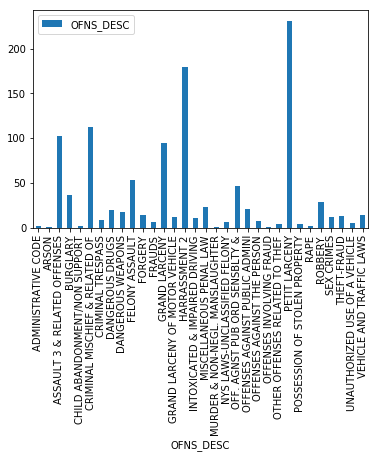

In [9]:
pd.DataFrame(one_day.groupby('OFNS_DESC')['OFNS_DESC'].count()).plot(kind='bar')

In [7]:
lat_0 = (min(crime_data['Latitude']) + max(crime_data['Latitude']))/2
lon_0 = (min(crime_data['Longitude']) + max(crime_data['Longitude']))/2

colors = {}
for c in set(one_day["OFNS_DESC"]):
    colors[c] = (random.randint(1, 257), random.randint(1, 257), random.randint(1, 257))

    
l = []
for c in colors.keys():
    s = Scattermapbox(
        lat= one_day[one_day["OFNS_DESC"] == c]['Latitude'],
        lon=one_day[one_day["OFNS_DESC"] == c]['Longitude'],
        mode='markers',
        name= c,
        marker=Marker(
            size=9,
            #color=colors[c]
        ),
        text=one_day["OFNS_DESC"],
    )
    l.append(s)
data = Data(l)
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=lat_0,
            lon=lon_0
        ),
        pitch=0,
        zoom=10
    ),
    showlegend= True,
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Crime_NYC_6-30-17')

In [8]:
###Histogram 2D for petit Larceny
x = one_day[one_day['OFNS_DESC'] == 'PETIT LARCENY']['Latitude']
min_x = min(one_day[one_day['OFNS_DESC'] == 'PETIT LARCENY']['Latitude'])
max_x = max(one_day[one_day['OFNS_DESC'] == 'PETIT LARCENY']['Latitude'])
y = one_day[one_day['OFNS_DESC'] == 'PETIT LARCENY']['Longitude']
min_y = min(one_day[one_day['OFNS_DESC'] == 'PETIT LARCENY']['Longitude'])
max_y = max(one_day[one_day['OFNS_DESC'] == 'PETIT LARCENY']['Longitude'])

data = [
    Histogram2d(x=x, y=y, histnorm='',
        autobinx=False,
        xbins=dict(start=min_x, end=max_x, size=0.05),
        autobiny=False,
        ybins=dict(start=min_y, end=max_y, size=0.05),
        colorscale=[[0, 'rgb(12,51,131)'], [0.25, 'rgb(10,136,186)'], [0.5, 'rgb(242,211,56)'], [0.75, 'rgb(242,143,56)'], [1, 'rgb(217,30,30)']]
    )
]
py.iplot(data)

In [18]:
grid = np.histogram2d(x = one_day[one_day['OFNS_DESC'] == 'PETIT LARCENY']['Latitude'], 
                     y = one_day[one_day['OFNS_DESC'] == 'PETIT LARCENY']['Longitude'],
                     bins = [16, 16])
grid[0]

array([[  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,   2.,   0.,
          0.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   4.,   0.,   2.,
          0.,   0.,   0.,   0.,   3.],
       [  0.,   1.,   0.,   0.,   0.,   0.,   3.,   2.,   1.,   4.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   1.,   1.,   4.,
          2.,   1.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   2.,   2.,
          5.,   0.,   1.,   2.,   2.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   1.,   7.,   3.,
          0.,   3.,   2.,   1.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   8.,   3.,   1.,   1.,
          2.,   2.,   